# CFD Simulation of a NACA 0012 Airfoil
## 0. Computational Environment
**Tool:** OpenFOAM v13
* **Operating System:** Windows Subsystem for Linux (WSL2) - Ubuntu
* **IDE:** Visual Studio Code (Remote - WSL extension)
**Solver:** `simpleFoam` (Steady-state, Incompressible RANS)

## 1. Objective
The goal of this simulation is to compute the aerodynamic coefficients (Lift $C_l$ and Drag $C_d$) of a symmetric **NACA 0012** airfoil. We will compare the results against standard aerodynamic theory to validate the setup.

## 2. Physical Setup
* **Geometry:** NACA 0012 Airfoil (Chord $c = 1.0\,m$)
* **Domain:** 2D "Wind Tunnel" (C-Grid or Box topology)
    * Inlet: 5c upstream
    * Outlet: 15c downstream
    * Top/Bottom: 10c clearance
* **Fluid:** Air (Incompressible, Newtonian)
* **Turbulence Model:** $k-\omega$ SST (Shear Stress Transport)
    * Selected for its superior performance in adverse pressure gradients and boundary layer separation.

## 3. Flow Conditions
| Parameter | Symbol | Value | Unit |
| :--- | :---: | :---: | :---: |
| Free Stream Velocity | $U_\infty$ | **100** | $m/s$ |
| Chord Length | $c$ | **1.0** | $m$ |
| Kinematic Viscosity | $\nu$ | **1.5e-5** | $m^2/s$ |
| Reynolds Number | $Re$ | **6.67e6** | - |
| Angle of Attack | $\alpha$ | **0°** | $deg$ |

## 4. Methodology
The simulation workflow follows the standard OpenFOAM process:
1.  **Pre-Processing:**
    * `blockMesh`: Generate background domain.
    * `snappyHexMesh`: Carve the airfoil geometry from the background.
    * `extrudeMesh`: Convert the 3D mesh into a 2D plane (1 cell thick).
2.  **Solver Settings:**
    * Using `simpleFoam` for steady-state convergence.
    * `GAMG` solver for Pressure, `smoothSolver` for Velocity/Turbulence.
3.  **Post-Processing:**
    * Monitor residuals and force coefficients ($C_l, C_d$).
    * Visualize pressure ($C_p$) and velocity fields.

## Step 1: Directory Setup
We begin by creating the standard OpenFOAM case structure.
* **`0/`**: Initial boundary conditions (Velocity, Pressure).
* **`constant/`**: Physical properties (Viscosity) and the Mesh.
    * `triSurface/`: Stores the `.stl` geometry file.
* **`system/`**: Solver controls and meshing dictionaries.

In [1]:
%%bash
mkdir -p airfoilCase/system
mkdir -p airfoilCase/constant/triSurface
mkdir -p airfoilCase/0

install required python libraries for this project

In [2]:
!pip install cadquery numpy osc pyvista

## Step 2: Geometry Generation (Python + CadQuery)
We define the **NACA 0012** profile using its analytical equation.
* **Cosine Spacing** is used to cluster points at the leading and trailing edges for better curvature resolution.
* The 2D profile is extruded by `0.1m` to create a pseudo-3D volume required by OpenFOAM.
* **Output:** `constant/triSurface/airfoil.stl`

In [3]:
import os
import numpy as np
import cadquery as cq

### Parameters

In [4]:
chord = 1.0       # chord length in m
t = 0.12          # thickness fraction (NACA 0012 -> 0.12)
n_points = 200    # resolution along chord
span = 0.1        # extrusion span (thickness) in m

In [5]:
# Cosine spacing
beta = np.linspace(0, np.pi, n_points)
x = (1 - np.cos(beta)) / 2

# NACA 4-digit thickness distribution (symmetric)
yt = 5 * t * (0.2969 * np.sqrt(x) - 0.1260 * x - 0.3516 * x**2 + 0.2843 * x**3 - 0.1015 * x**4)

# Build closed airfoil profile (trailing -> upper -> leading -> lower -> trailing)
xu = x[::-1] * chord
yu = yt[::-1] * chord
xl = x * chord
yl = -yt * chord

points = []
points.append((chord, 0.0))                 # trailing edge start
points += list(zip(xu, yu))                 # upper surface to leading edge
points += list(zip(xl[1:], yl[1:]))         # lower surface back to trailing (skip duplicate leading pt)
points.append((chord, 0.0))                 # close at trailing edge

### Create 3D solid by extruding the 2D profile

In [6]:

airfoil = cq.Workplane("XY").polyline(points).close().extrude(span)

### Export STL (meters)

In [7]:
out_dir = "airfoilCase/constant/triSurface"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "airfoil.stl")
cq.exporters.export(airfoil, out_path)

System

## Step 3: Background Mesh (blockMesh)
We define the "Virtual Wind Tunnel" domain.
* **Dimensions:** 20m (Length) x 20m (Height) x 0.2m (Thickness).
* **Topology:** A single hexahedral block.
* **Resolution:** Coarse base mesh (40x20x1). We will rely on `snappyHexMesh` to refine this later near the wing.
* **2D Constraint:** The `front` and `back` patches are set to type `empty` to enforce 2D flow.

In [ ]:
%%bash
cat <<EOF > airfoilCase/system/blockMeshDict
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    object      blockMeshDict;
}

convertToMeters 1;

vertices
(
    (-5 -10 0)    // 0 Bottom-Inlet-Front
    (15 -10 0)    // 1 Bottom-Outlet-Front
    (15  10 0)    // 2 Top-Outlet-Front
    (-5  10 0)    // 3 Top-Inlet-Front
    (-5 -10 0.2)  // 4 Bottom-Inlet-Back (z=0.2)
    (15 -10 0.2)  // 5 Bottom-Outlet-Back
    (15  10 0.2)  // 6 Top-Outlet-Back
    (-5  10 0.2)  // 7 Top-Inlet-Back
);

blocks
(
    // Coarse background mesh: 40 cells (X) x 20 cells (Y) x 1 cell (Z)
    hex (0 1 2 3 4 5 6 7) (60 40 1) simpleGrading (1 1 1)
);

edges ();

boundary
(
    inlet
    {
        type patch;
        faces ((0 3 7 4));
    }
    outlet
    {
        type patch;
        faces ((1 5 6 2));
    }
    topAndBottom
    {
        type patch; // Will be walls or slip
        faces ((0 1 5 4) (3 2 6 7));
    }
    front
    {
        type empty;
        faces ((0 1 2 3)); // The Z=0 face ONLY
    }
    back
    {
        type empty;
        faces ((4 5 6 7)); // The Z=0.2 face ONLY
    }
);
EOF

## Step 4: Feature Extraction (surfaceFeaturesDict)
We configure `surfaceFeatureExtract` to identify sharp edges in the geometry.
* **Objective:** Capture the **Trailing Edge** of the airfoil crisply.
* **Threshold:** `includedAngle 150` ensures that the sharp tail is detected while the smooth leading edge is ignored.
* **Output:** An `.eMesh` file that `snappyHexMesh` uses to snap grid points to the geometry edges.

In [9]:
%%bash
cat <<EOF > airfoilCase/system/surfaceFeaturesDict
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    object      surfaceFeaturesDict;
}

extractionMethod    extractFromSurface;
includedAngle       150;
writeObj            yes;

surfaces
(
    "airfoil.stl"
);
EOF

## Step 5: Mesh Refinement (snappyHexMeshDict)
We configure the 3-step meshing process:
1.  **Castellated Mesh:** Refines the background grid around the airfoil (Levels 3-4).
2.  **Snap:** smooths the jagged edges to conform to the STL surface.
3.  **Add Layers:** Inserts 3 prism layers near the wall to resolve the boundary layer (crucial for drag prediction).
* **Location in Mesh:** `(2 2 0.1)` identifies the "fluid" region to keep.

## Theory: Wall Spacing ($y+$)
To accurately predict drag and flow separation, we must resolve the **boundary layer**—the thin layer of fluid near the surface where viscosity dominates.

The dimensionless wall distance, $y+$, is defined as:
$$y+ = \frac{u_* y}{\nu}$$

Where:
* $u_*$: Friction velocity ($\sqrt{\tau_w / \rho}$)
* $y$: Height of the first cell center from the wall.
* $\nu$: Kinematic viscosity.

### Strategy for k-$\omega$ SST
The **k-$\omega$ SST** model works in two modes:
1.  **Low-Re (Resolved):** $y+ < 1$. Resolves the viscous sublayer directly. Most accurate for drag/separation.
2.  **High-Re (Wall Functions):** $30 < y+ < 300$. Models the inner layer using empirical equations. Faster, but less accurate for separation.

### Calculation for this Case
For $Re = 6.67 \times 10^6$ and a target $y+ \approx 30$ (using Wall Functions for efficiency):
1.  **Skin Friction ($C_f$ estimate):**
    $$C_f = 0.0576 Re^{-1/5} \approx 0.0025$$
2.  **Wall Shear Stress ($\tau_w$):**
    $$\tau_w = \frac{1}{2} \rho U^2 C_f \approx \frac{1}{2}(1.225)(100^2)(0.0025) \approx 15.3 \, Pa$$
3.  **Friction Velocity ($u_*$):**
    $$u_* = \sqrt{\tau_w / \rho} \approx \sqrt{15.3 / 1.225} \approx 3.53 \, m/s$$
4.  **First Cell Height ($y$):**
    $$y = \frac{(y+) \nu}{u_*} = \frac{30 \times 1.5e^{-5}}{3.53} \approx 0.000127 \, m \, (0.13 \, mm)$$

*Note: In `snappyHexMeshDict`, our `finalLayerThickness` and expansion ratio attempt to target this range, though may vary locally.*

In [ ]:
%%bash
cat <<EOF > airfoilCase/system/snappyHexMeshDict
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    object      snappyHexMeshDict;
}

castellatedMesh true;
snap            true;
addLayers       true;

geometry
{
    airfoil
    {
        type triSurfaceMesh;
        file "airfoil.stl";
    }
}

castellatedMeshControls
{
    maxLocalCells 1000000;
    maxGlobalCells 2000000;
    minRefinementCells 10;
    maxLoadUnbalance 0.10;
    nCellsBetweenLevels 3;

    features
    (
        {
            file "airfoil.eMesh";
            level 3;
        }
    );

    refinementSurfaces
    {
        airfoil
        {
            level (6 8);
        }
    }

    resolveFeatureAngle 30;

    refinementRegions
    {
        airfoil
        {
            mode distance;
            levels ((0.5 4) (1.0 3));
        }
    }

    // A point inside the tunnel but OUTSIDE the airfoil
    locationInMesh (2 2 0.1); 

    allowFreeStandingZoneFaces true;
}

snapControls
{
    nSmoothPatch 3;
    tolerance 2.0;
    nSolveIter 30;
    nRelaxIter 5;
    nFeatureSnapIter 10;
    implicitFeatureSnap false;
    explicitFeatureSnap true;
    multiRegionFeatureSnap false;
}

addLayersControls
{
    relativeSizes true;
    layers
    {
        airfoil
        {
            nSurfaceLayers 3;
        }
    }
    expansionRatio 1.2;
    finalLayerThickness 0.5;
    minThickness 0.1;
    nGrow 0;
    featureAngle 60;
    slipFeatureAngle 30;
    nRelaxIter 3;
    nSmoothSurfaceNormals 1;
    nSmoothNormals 3;
    nSmoothThickness 10;
    maxFaceThicknessRatio 0.5;
    maxThicknessToMedialRatio 0.3;
    minMedianAxisAngle 90;
    nBufferCellsNoExtrude 0;
    nLayerIter 50;
}

meshQualityControls
{
    maxNonOrtho 65;
    maxBoundarySkewness 20;
    maxInternalSkewness 4;
    maxConcave 80;
    minVol 1e-13;
    minTetQuality 1e-30;
    minArea -1;
    minTwist 0.05;
    minDeterminant 0.001;
    minFaceWeight 0.05;
    minVolRatio 0.01;
    minTriangleTwist -1;
    nSmoothScale 4;
    errorReduction 0.75;
}

mergeTolerance 1e-6;
EOF

## Step 6: Convert to 2D (extrudeMeshDict)
This step converts the 3D mesh generated by `snappyHexMesh` into a pseudo-2D mesh required for the simulation.
* **Method:** We take the `front` patch of the 3D mesh and extrude it by **1 cell** in the Z-direction.
* **Outcome:** A new mesh that is exactly 1 cell thick, with `front` and `back` patches ready for `empty` boundary conditions.
* **Fix:** `flipNormals true` prevents the creation of negative volume (inverted) cells.

In [11]:
%%bash
cat <<EOF > airfoilCase/system/extrudeMeshDict
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    object      extrudeMeshDict;
}

constructFrom patch;
sourceCase ".";
sourcePatches (front); // Start from the front face
exposedPatchName back; // Name the new face 'back'
flipNormals true;
extrudeModel        linearDirection;
linearDirectionCoeffs
{
    direction       (0 0 1);
    thickness       0.2;
    nLayers         1;
    expansionRatio  1.0;
}

mergeFaces false; 
mergeTol 0;
EOF

## Step 7: Solver Control & Force Monitoring (controlDict)
This file acts as the "Simulation Controller." It defines the time steps, write intervals, and specifically how to calculate aerodynamic forces.

### Key Settings:
* **Solver:** `simpleFoam` (Steady-state, Incompressible RANS).
* **Time Management:**
    * `endTime 2000`: Runs for 2000 iterations to ensure convergence.
    * `writeInterval 100`: Saves full field data every 100 steps.

### Aerodynamic Coefficients ($C_l, C_d$)
The `functions` block calculates Lift and Drag "on the fly" using the standard formula:
$$C_x = \frac{Force_x}{0.5 \rho U_\infty^2 A_{ref}}$$

**Critical Reference Values (Must match Geometry/Physics):**
* **$\rho$ (Density):** $1.225 \, kg/m^3$ (Standard Air).
* **$U_\infty$ (Velocity):** **100 m/s** (Matches Inlet).
* **$A_{ref}$ (Reference Area):** **0.2 $m^2$**.
    * Calculated as: $Chord (1.0m) \times Thickness (0.2m)$.
    * *Note:* Since OpenFOAM is 3D, we must normalize by the thickness of our "2D" slice.

In [12]:
%%bash
cat <<EOF > airfoilCase/system/controlDict
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      controlDict;
}

application     simpleFoam; // Steady-state solver for incompressible flow
startFrom       startTime;
startTime       0;
stopAt          endTime;
endTime         2000;       // Max number of iterations
deltaT          1;          // For steady state, this is just an iteration counter
writeControl    timeStep;
writeInterval   100;        // Save fields every 100 iterations
purgeWrite      0;
writeFormat     ascii;
writePrecision  6;
writeCompression off;
timeFormat      general;
timePrecision   6;
runTimeModifiable true;

functions
{
    forces
    {
        type            forceCoeffs;
        libs            ("libforces.so");
        writeControl    timeStep;
        writeInterval   1;

        patches         (airfoil); // Must match the name in snappyHexMeshDict
        rho             rhoInf;
        log             true;
        rhoInf          1.225;     // Density (kg/m^3)
        CofR            (0.25 0 0); // Center of rotation (25% chord)
        liftDir         (0 1 0);    // Lift is Y-axis
        dragDir         (1 0 0);    // Drag is X-axis
        pitchAxis       (0 0 1);
        magUInf         100.0;       // Free stream velocity (m/s)
        lRef            1.0;        // Chord length (m)
        Aref            0.2;        // Reference area (Chord * Span = 1.0 * 0.2)
    }
}
EOF

## Step 8: Numerical Schemes (fvSchemes)
This file defines how we convert the continuous differential equations into algebraic equations (Discretization).

### Key Selections:
* **`ddtSchemes`:** `steadyState` (Time is just an iteration counter).
* **`div(phi,U)`:** `linearUpwind` (2nd Order). High accuracy for velocity is required to capture the boundary layer profile and drag correctly.
* **`div(phi,k)`:** `upwind` (1st Order). High stability is required for turbulence quantities to prevent them from becoming negative.
* **`wallDist`:** Using `meshWave`. Essential for the **k-omega SST** model to calculate wall distance ($y$) for its internal blending functions.

In [13]:
%%bash
cat <<EOF > airfoilCase/system/fvSchemes
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      fvSchemes;
}

ddtSchemes
{
    default         steadyState;
}

gradSchemes
{
    default         Gauss linear;
    grad(U)         cellLimited Gauss linear 1; // Improved stability for SST
}

divSchemes
{
    default         none;
    div(phi,U)      bounded Gauss linearUpwind grad(U);
    div(phi,k)      bounded Gauss upwind;
    div(phi,omega)  bounded Gauss upwind;
    div(phi,nut)    bounded Gauss upwind;
    div((nuEff*dev2(T(grad(U))))) Gauss linear;
}

laplacianSchemes
{
    default         Gauss linear corrected;
}

interpolationSchemes
{
    default         linear;
}

snGradSchemes
{
    default         corrected;
}

wallDist
{
    method          meshWave;
}
EOF

## Step 9: Linear Solver Settings (fvSolution)
This file controls the iterative solvers used to calculate the flow field.

### Key Configurations:
* **Pressure Solver:** `GAMG` (Multi-Grid). chosen for its superior speed in solving the elliptic pressure equation.
* **Algorithm:** `SIMPLEC` (activated by `consistent yes`). This variation of the SIMPLE algorithm allows for faster convergence by handling pressure-velocity coupling more consistently.
* **Relaxation Factors:** Set to **0.9** for all variables. This aggressive setting is only stable because `consistent yes` is active.
* **Convergence Criteria:** The solver will stop if residuals fall below `1e-4`.
    * *Note:* For accurate Drag ($C_d$) prediction, we must ensure the forces have flattened out, even if residuals are low.

In [14]:
%%bash 
cat <<EOF > airfoilCase/system/fvSolution
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      fvSolution;
}

solvers
{
    p
    {
        solver          GAMG;
        tolerance       1e-6;
        relTol          0.01;
        smoother        GaussSeidel;
    }

    "(U|k|omega|nut)"
    {
        solver          smoothSolver;
        smoother        symGaussSeidel;
        tolerance       1e-8;
        relTol          0.1;
    }
}

SIMPLE
{
    nNonOrthogonalCorrectors 0;
    consistent      yes;
    residualControl
    {
        p               1e-4;
        U               1e-4;
        "(k|omega)"     1e-4;
    }
}

relaxationFactors
{
    equations
    {
        U               0.9; 
        ".*"            0.9; 
    }
}
EOF

## Step 10: Mesh Generation & Execution
This cell runs the complete meshing pipeline:
1.  **`blockMesh`**: Creates the background box.
2.  **`surfaceFeatureExtract`**: Detects the sharp trailing edge so the mesher doesn't smooth it out.
3.  **`snappyHexMesh`**: Carves the airfoil shape (creates a 3D mesh).
4.  **`extrudeMesh`**: Flattens the 3D mesh into a 1-cell-thick 2D mesh.
5.  **`sed` (Stream Editor)**: Manually patches the boundary file to force `front` and `back` to type `empty` (fixing the 2D constraint).
6.  **`checkMesh`**: Verifies the mesh quality.

In [15]:
%%bash
cd airfoilCase

# 1. TEMPORARY FIX: Trick snappyHexMesh into thinking this is 3D
# We replace 'empty' with 'patch' in the blockMeshDict
sed -i 's/type empty/type patch/g' system/blockMeshDict

# 2. Generate Background Mesh (Now fully 3D)
echo "Running blockMesh..."
blockMesh > log.blockMesh

# 3. Extract Sharp Edges
echo "Running Feature Extraction..."
# Try standard command, fall back to user alias if needed
if command -v surfaceFeatureExtract &> /dev/null; then
    surfaceFeatureExtract > log.surfaceFeatures
else
    surfaceFeatures > log.surfaceFeatures
fi

# 4. Carve the Airfoil (3D)
# Snappy works now because there are no 'empty' patches
echo "Running snappyHexMesh..."
snappyHexMesh -overwrite > log.snappyHexMesh

# 5. Flatten to 2D
# This takes the 3D mesh and squashes it into 1 layer
echo "Running extrudeMesh..."
extrudeMesh > log.extrudeMesh

# 6. PERMANENT FIX: Restore 2D Constraints for the Solver
# Now we force the boundary file to say 'empty' again for the front and back
sed -i -r '/front/,/}/ s/type[ \t]+patch/type empty/' constant/polyMesh/boundary
sed -i -r '/back/,/}/ s/type[ \t]+patch/type empty/' constant/polyMesh/boundary

# 7. Verify
echo "Verifying Mesh..."
checkMesh > log.checkMesh
grep "Mesh OK" log.checkMesh || echo "WARNING: Check log.checkMesh"

Running blockMesh...
Running Feature Extraction...
Running snappyHexMesh...
Running extrudeMesh...
Verifying Mesh...
Mesh OK.


## Theory: Turbulence Initial Conditions
To initialize the **k-omega SST** model, we must define the turbulent kinetic energy ($k$) and specific dissipation rate ($\omega$) at the inlet.

We assume a **Turbulence Intensity ($I$) of 5%** (typical for general aerodynamics) and a **Turbulent Length Scale ($L$)** approx 10% of the chord.

### 1. Kinetic Energy ($k$)
$$k = \frac{3}{2} (U_\infty I)^2$$
* $U_\infty = 100 \, m/s$
* $I = 0.05$
* **$k = 1.5 \times (100 \times 0.05)^2 = 37.5 \, m^2/s^2$**

### 2. Specific Dissipation Rate ($\omega$)
$$\omega = \frac{\sqrt{k}}{C_\mu^{0.25} L}$$
* $C_\mu = 0.09$ (Standard constant)
* $L \approx 0.1 \, m$ (Characteristic mixing length)
* **$\omega \approx \frac{\sqrt{37.5}}{0.55 \times 0.1} \approx 110 \, s^{-1}$**

> **Note:** These values will be used in the `0/k` and `0/omega` files.

## Step 11: Initial Velocity Field (0/U)
We define the starting velocity for the simulation.

### Key Boundary Conditions:
* **Inlet:** `fixedValue (100 0 0)`.
    * Sets the free stream velocity to **100 m/s** (approx Mach 0.3).
    * Direction is aligned with the X-axis (0° Angle of Attack).
* **Airfoil:** `noSlip`.
    * Enforces the physical condition where fluid sticks to the wall (Velocity = 0). This creates the boundary layer and drag.
* **Top/Bottom:** `slip`.
    * Treats the tunnel walls as frictionless "symmetry planes" so they don't slow down the flow.
* **Outlet:** `inletOutlet`.
    * Allows flow to leave freely but prevents numerical instability if flow accidentally reverses (backflow) during the startup transient.

In [16]:
%%bash
cat <<EOF > airfoilCase/0/U
FoamFile
{
    version     2.0;
    format      ascii;
    class       volVectorField;
    location    "0";
    object      U;
}

dimensions      [0 1 -1 0 0 0 0]; // m/s

internalField   uniform (100 0 0); // Initial guess: 100 m/s everywhere

boundaryField
{
    inlet
    {
        type            fixedValue;
        value           uniform (95 5 0); 
    }

    outlet
    {
        type            inletOutlet; // Robust outlet condition
        inletValue      uniform (0 0 0); // Prevents backflow crashing
        value           uniform (10 0 0);
    }

    topAndBottom
    {
        type            slip; // Frictionless walls
    }

    airfoil
    {
        type            noSlip; // Sticky wall
    }

    front
    {
        type            empty; // 2D Constraint
    }

    back
    {
        type            empty; // 2D Constraint
    }
}
EOF

## Step 12: Initial Pressure Field (0/p)
We define the starting pressure for the simulation.

### Important Note: Kinematic Pressure
Because `simpleFoam` is an incompressible solver, it solves for **Kinematic Pressure** ($p/\rho$) rather than physical pressure (Pa).
* **Dimensions:** $m^2/s^2$ (Velocity squared).
* **Conversion:** To get Pascals, multiply the result by density ($\rho = 1.225$).

### Boundary Conditions:
* **Inlet/Walls:** `zeroGradient` (Neumann). The pressure adjusts naturally to the flow.
* **Outlet:** `fixedValue 0` (Dirichlet). This "pins" the system to atmospheric pressure at the exit, providing a reference point for the solver.

In [17]:
%%bash 
cat <<EOF > airfoilCase/0/p
FoamFile
{
    version     2.0;
    format      ascii;
    class       volScalarField;
    location    "0";
    object      p;
}

dimensions      [0 2 -2 0 0 0 0]; // m^2/s^2

internalField   uniform 0;

boundaryField
{
    inlet
    {
        type            zeroGradient;
    }

    outlet
    {
        type            fixedValue;
        value           uniform 0;
    }

    topAndBottom
    {
        type            zeroGradient;
    }

    airfoil
    {
        type            zeroGradient;
    }

    front
    {
        type            empty;
    }

    back
    {
        type            empty;
    }
}
EOF

## Step 14: Turbulent Kinetic Energy (0/k)
We define the energy contained in the turbulent eddies.

### Physics Check:
* **Value:** **37.5 $m^2/s^2$**.
* **Formula:** $k = \frac{3}{2}(U I)^2$
    * With $U=100 \, m/s$ and $I=5\%$, $k$ is significantly higher than in low-speed cases.
    * *Note:* Using the correct $k$ is crucial for the **SST model** to trigger the transition from laminar to turbulent flow at the correct location on the wing.

### Boundary Conditions:
* **Airfoil:** `kqRWallFunction`.
    * This condition handles the near-wall turbulence. Since our mesh has $y+ \approx 30$, we rely on this wall function to model the energy peak in the buffer layer that we aren't resolving directly.

In [18]:
%%bash
cat <<EOF > airfoilCase/0/k
FoamFile
{
    version     2.0;
    format      ascii;
    class       volScalarField;
    object      k;
}

dimensions      [0 2 -2 0 0 0 0];

internalField   uniform 37.5;

boundaryField
{
    inlet
    {
        type            fixedValue;
        value           uniform 37.5;
    }
    outlet
    {
        type            inletOutlet;
        inletValue      uniform 37.5;
        value           uniform 37.5;
    }
    topAndBottom
    {
        type            slip;
    }
    airfoil
    {
        type            kqRWallFunction; // Wall function for k
        value           uniform 37.5;
    }
    front
    {
        type            empty;
    }
    back
    {
        type            empty;
    }
}
EOF

## Step 15: Specific Dissipation Rate (0/omega)
We define the rate at which turbulent energy dissipates (frequency).

### Physics Check:
* **Value:** **110 $s^{-1}$**.
* **Why this matters:**
    * The turbulent viscosity is calculated as $\nu_t = k / \omega$.
    * If $\omega$ is too low (e.g., 5.0), the calculated viscosity becomes enormous, making the air act like molasses and destroying the accuracy of the drag prediction.
* **Boundary Condition:** `omegaWallFunction`.
    * This allows the solver to calculate the incredibly high values of $\omega$ that physically exist right at the wall surface without needing a microscopic mesh.

In [19]:
%%bash
cat <<EOF > airfoilCase/0/omega
FoamFile
{
    version     2.0;
    format      ascii;
    class       volScalarField;
    object      omega;
}

dimensions      [0 0 -1 0 0 0 0];

internalField   uniform 110.0;

boundaryField
{
    inlet
    {
        type            fixedValue;
        value           uniform 110.0;
    }
    outlet
    {
        type            inletOutlet;
        inletValue      uniform 110.0;
        value           uniform 110.0;
    }
    topAndBottom
    {
        type            slip;
    }
    airfoil
    {
        type            omegaWallFunction;
        value           uniform 110.0;
    }
    front
    {
        type            empty;
    }
    back
    {
        type            empty;
    }
}
EOF

## Step 16: Turbulent Viscosity (0/nut)
We define the boundary conditions for the eddy viscosity ($\nu_t$).

### Key Concept:
This is not a physical property of the air, but a computed field that models how turbulence mixes the flow.
* **Inlet/Outlet:** `type calculated`. The solver derives this from $k$ and $\omega$.
* **Airfoil:** `nutkWallFunction`. This boundary condition is essential for accurate drag prediction. It calculates the effective viscosity at the wall based on the local Reynolds number ($y+$), handling the transition through the boundary layer.

In [20]:
%%bash
cat <<EOF > airfoilCase/0/nut
FoamFile
{
    version     2.0;
    format      ascii;
    class       volScalarField;
    object      nut;
}

dimensions      [0 2 -1 0 0 0 0];

internalField   uniform 0;

boundaryField
{
    inlet
    {
        type            calculated;
        value           uniform 0;
    }
    outlet
    {
        type            calculated;
        value           uniform 0;
    }
    topAndBottom
    {
        type            slip;
    }
    airfoil
    {
        type            nutkWallFunction;
        value           uniform 0;
    }
    front
    {
        type            empty;
    }
    back
    {
        type            empty;
    }
}
EOF

## Step 17: Fluid Properties (transportProperties)
We define the physical characteristics of the fluid.
* **Model:** `Newtonian` (Standard air/water behavior).
* **$\nu$ (Nu):** $1.5 \times 10^{-5} \, m^2/s$.
    * This defines the fluid as **Air** at standard temperature and pressure.
    * This value is the mathematical anchor for the Reynolds Number ($Re \approx 6.67 \times 10^6$).

In [21]:
%%bash
cat <<EOF > airfoilCase/constant/transportProperties
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    object      transportProperties;
}

transportModel  Newtonian;
nu              [0 2 -1 0 0 0 0] 1.5e-05; // Kinematic viscosity of air
EOF

## Step 18: Turbulence Model (turbulenceProperties)
We select the Reynolds-Averaged Navier-Stokes (RAS) model.

### Model: `kOmegaSST` (Menter's Shear Stress Transport)
This is the industry standard for external aerodynamics because it solves the "Two-Layer Problem":
1.  **Inner Layer (Boundary Layer):** Uses $k-\omega$ for accurate separation prediction.
2.  **Outer Layer (Free Stream):** Uses $k-\epsilon$ for numerical stability.
* **`turbulence on`:** Activates the model.
* **`printCoeffs on`:** Prints the model constants (like $a_1$, $\beta^*$) to the log for verification.

In [22]:
%%bash
cat <<EOF > airfoilCase/constant/turbulenceProperties
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    object      turbulenceProperties;
}

simulationType  RAS;

RAS
{
    model           kOmegaSST;
    turbulence      on;
    printCoeffs     on;
}
EOF

## Step 19: Execution & Log Parsing
We execute the solver and immediately process the logs for analysis.
* **`simpleFoam`**: The iterative solver for steady-state incompressible flow.
* **`tee log.simpleFoam`**: Redirects output to a file while allowing us to monitor progress in the console.
* **`foamLog`**: A utility that extracts residuals and force coefficients from the text log into formatted data files.
    * These files will be stored in the `logs/` directory for easy plotting in the next step.

In [27]:
%%bash
cd airfoilCase
foamRun -solver incompressibleFluid | tee log.simpleFoam 
foamLog log.simpleFoam

/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     | Website:  https://openfoam.org
    \\  /    A nd           | Version:  13
     \\/     M anipulation  |
\*---------------------------------------------------------------------------*/
Build  : 13-cde978a97c93
Exec   : foamRun -solver incompressibleFluid
Date   : Feb 16 2026
Time   : 20:51:01
Host   : "Radin"
PID    : 19664
I/O    : uncollated
Case   : /home/radin/OpenFOAM/radin-13/run/airfoilCase
nProcs : 1
sigFpe : Enabling floating point exception trapping (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time modified files using timeStampMaster (fileModificationSkew 10)
allowSystemOperations : Allowing user-supplied system call operations

// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //
Create time

Create mesh for time = 0

Selecting solv

## Step 20: Convergence Analysis (Python Plotting)
We use Matplotlib to visualize the simulation progress. 

### Why we plot this:
1.  **Residuals:** To ensure the mathematical solvers have reached a stable solution. Standard practice requires residuals to drop below at least $10^{-4}$.
2.  **Force Coefficients:** To confirm that the physical properties ($C_l$ and $C_d$) have stopped changing. A simulation can have low residuals but still have "drifting" forces; we only trust the result when these lines are flat.
3.  **Validation:** For a NACA 0012 at 0° AoA, we expect $C_l \approx 0$ and $C_d$ to be a small value (typically around $0.006 - 0.012$ depending on the turbulence model and Reynolds number).

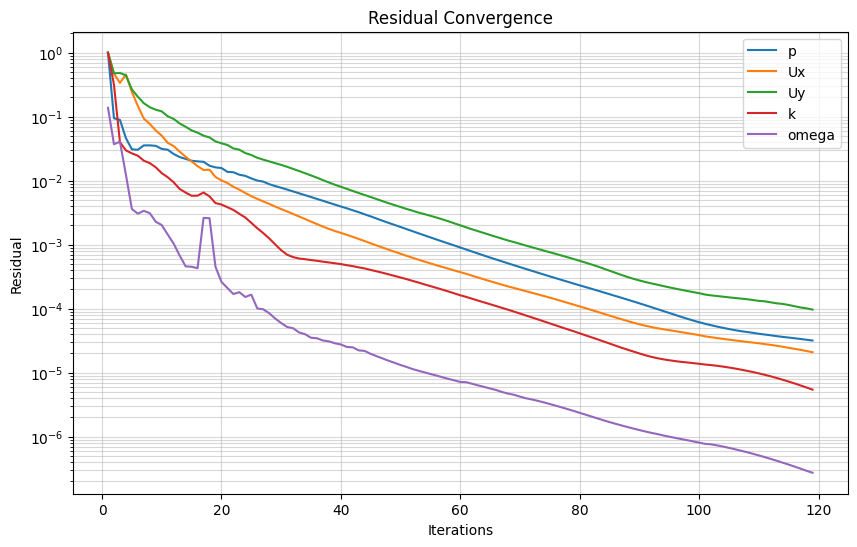

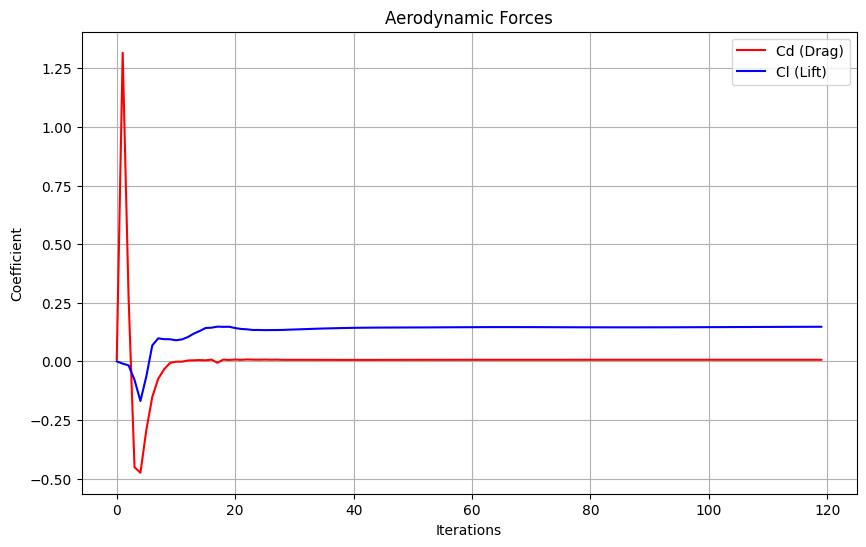

Final Cd: 0.00671
Final Cl: 0.14753
Lift-to-Drag Ratio (L/D): 21.98 (Efficiency)


In [24]:
import matplotlib.pyplot as plt
import os

# --- Configuration ---
log_dir = 'airfoilCase/logs'  # The folder created by foamLog
figsize = (10, 6)

# --- Helper function to read foamLog files ---
def read_log_file(filename):
    filepath = os.path.join(log_dir, filename)
    if not os.path.exists(filepath):
        print(f"Warning: {filename} not found.")
        return [], []
    
    x = []
    y = []
    with open(filepath, 'r') as f:
        for line in f:
            if line.startswith('#'): continue
            parts = line.split()
            if len(parts) >= 2:
                # --- THE FIX: Remove 's' if present ---
                time_str = parts[0].replace('s', '') 
                try:
                    val_x = float(time_str)
                    val_y = float(parts[1])
                    x.append(val_x)
                    y.append(val_y)
                except ValueError:
                    continue # Skip lines that are still headers
    return x, y

# --- PLOT 1: RESIDUALS ---
plt.figure(figsize=figsize)
fields_to_plot = ['p_0', 'Ux_0', 'Uy_0', 'k_0', 'omega_0']
has_data = False

for field in fields_to_plot:
    iters, values = read_log_file(field)
    if iters:
        plt.plot(iters, values, label=field.replace('_0', ''))
        has_data = True

if has_data:
    plt.yscale('log')
    plt.title('Residual Convergence')
    plt.xlabel('Iterations')
    plt.ylabel('Residual')
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.legend()
    plt.show()
else:
    print("No residual data found. Did you run 'foamLog log.simpleFoam'?")

# --- PLOT 2: FORCES (Cd & Cl) ---
force_file = "airfoilCase/postProcessing/forces/0/forceCoeffs.dat"

if os.path.exists(force_file):
    iters, cd, cl = [], [], []
    with open(force_file, 'r') as f:
        for line in f:
            if line.startswith('#'): continue
            parts = line.split()
            if len(parts) >= 4:
                try:
                    # Fix time string here too
                    t_val = float(parts[0].replace('s', ''))
                    iters.append(t_val)
                    cd.append(float(parts[2])) 
                    cl.append(float(parts[3])) 
                except ValueError:
                    continue

    if iters:
        plt.figure(figsize=figsize)
        plt.plot(iters, cd, label='Cd (Drag)', color='red')
        plt.plot(iters, cl, label='Cl (Lift)', color='blue')
        
        plt.title('Aerodynamic Forces')
        plt.xlabel('Iterations')
        plt.ylabel('Coefficient')
        plt.grid(True)
        plt.legend()
        plt.show()
        
        print(f"Final Cd: {cd[-1]:.5f}")
        print(f"Final Cl: {cl[-1]:.5f}")
        print(f"Lift-to-Drag Ratio (L/D): {cl[-1]/cd[-1]:.2f} (Efficiency)")
else:
    print("Force coefficients log not found.")